In [ ]:
!nvidia-smi

Sat Jan 15 10:29:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-01-15 10:29:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-15 10:29:25 (99.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get Data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2022-01-15 10:29:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.112, 172.217.164.144, 142.251.45.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   149MB/s    in 0.9s    

2022-01-15 10:29:28 (149 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


data_aug = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255),
], name="data_aug")

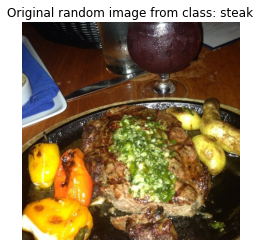

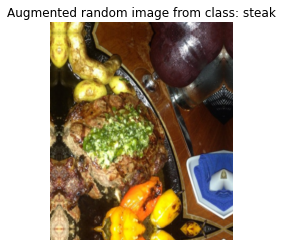

In [ ]:


# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_aug(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);


In [ ]:
input_shape= (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_aug(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1 = keras.Model(inputs, outputs)
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_1_percent = model_1.fit(train_data_1_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_1_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)), 
                                 callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_feature_extract")])

16719872/16705208 [==============================] - 0s 0us/step
Saving TensorBoard log files to: transfer_learning/1_percent_feature_extract/20220115-102935
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


3/3 [==============================] - 19s 2s/step - loss: 2.3794 - accuracy: 0.1000 - val_loss: 2.2283 - val_accuracy: 0.2023
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.0956 - accuracy: 0.2714 - val_loss: 2.1014 - val_accuracy: 0.2763
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.8865 - accuracy: 0.5286 - val_loss: 1.9945 - val_accuracy: 0.3536
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7312 - accuracy: 0.6143 - val_loss: 1.9086 - val_accuracy: 0.3980
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6261 - accuracy: 0.6143 - val_loss: 1.8389 - val_accuracy: 0.4539


In [ ]:
model_1.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 1.8389 - accuracy: 0.4608


[1.838887095451355, 0.4607999920845032]

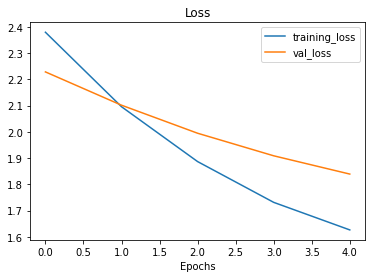

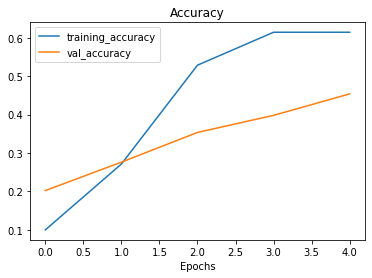

In [ ]:
plot_loss_curves(history_1_percent)

## Model with 10 percent

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

--2022-01-15 10:30:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 142.250.65.80, 142.250.188.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   262MB/s    in 0.6s    

2022-01-15 10:30:28 (262 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
train_data_10p = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                     label_mode='categorical',
                                                                     image_size=IMG_SIZE)

test_data_10p = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                     label_mode='categorical',
                                                                     image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_aug = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255),
], name="data_aug")

In [ ]:
input_shape = (224,224,3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_aug(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
outputs = layers.Dense(10, activation="softmax", name="ouput_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)


model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])



In [ ]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch',
                                                         verbose=1)

In [ ]:
initial_epochs = 5

history_10p = model_2.fit(train_data_10p,
            epochs=initial_epochs,
            validation_data=test_data,
            validation_steps=int(0.25 * len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name="tramsfer_L",
                                                   experiment_name="10_percent_data_aug"),checkpoint_callback])

Saving TensorBoard log files to: tramsfer_L/10_percent_data_aug/20220115-103804
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - ETA: 0s - loss: 0.7469 - accuracy: 0.8120
Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 8s 330ms/step - loss: 0.7469 - accuracy: 0.8120 - val_loss: 0.6732 - val_accuracy: 0.8043
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.6825 - accuracy: 0.8280
Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 9s 356ms/step - loss: 0.6825 - accuracy: 0.8280 - val_loss: 0.6127 - val_accuracy: 0.8224
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.6256 - accuracy: 0.8520
Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 9s 343ms/step - loss: 0.6256 - accuracy: 0.8520 - val_loss: 0.6069 - val_accuracy: 0.8174
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.5892 - accuracy: 0.8

In [ ]:
model_1.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.6828 - accuracy: 0.8140


[0.682837188243866, 0.8140000104904175]

In [ ]:
res_10p = model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.7029 - accuracy: 0.8116


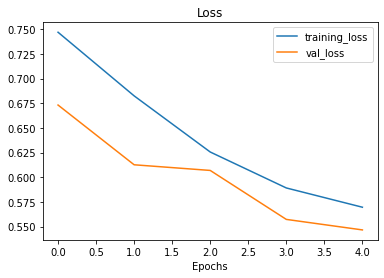

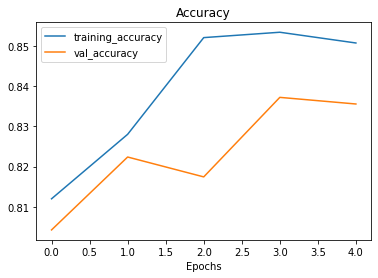

In [ ]:
plot_loss_curves(history_10p)